<a href="https://colab.research.google.com/github/harikang/yai_implementation/blob/GPT-Series/GPT2implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# GPT 1에서 GPT2로의 약간의 변화 이후, 모델 구조에서 크게 변한 것은 없기 때문에 GPT2을 구현.
# GPT2는 Transformer의 Decoder만을 사용함.

# GPT2 Workflow
(https://wikidocs.net/161980)

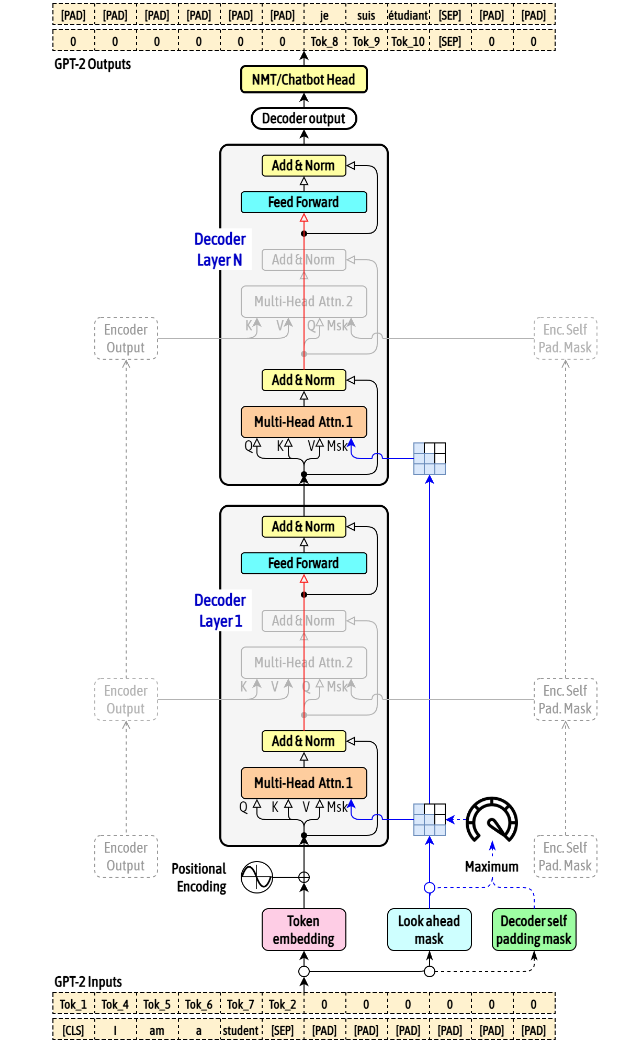



* GPT-2의 경우에는 "scale the weights of residual layers"부분과
 Layer normalization at the input of each sub-block"부분만 변경된것
* AR 적용, 각 토큰이 생성된 후 해당 토큰이 추가됨.
* GPT2는 Decoder를 쌓은 모델이고, 각 decoder layer는 masked self-attention을 사용함.




# GPT2 Masked Self-Attention
- gpt2에는 12개의 attention head가 존재함.


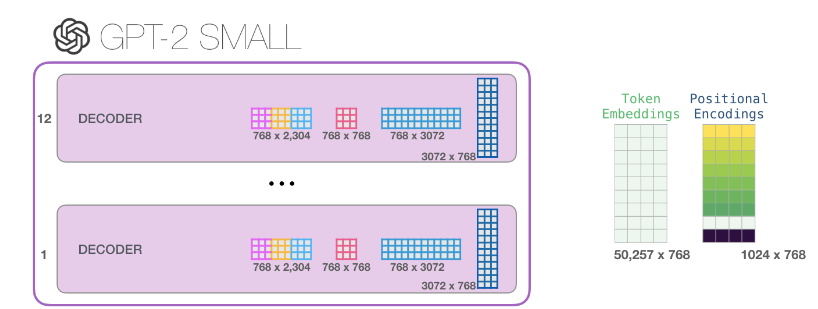

# GPT 모델은 기존에 구현한 TRANSFORMER와 완전 유사.

In [ ]:
import torch
import torch.nn as nn

**Attention**

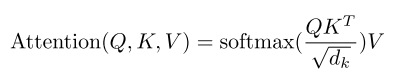

In [ ]:
class ScaledDotProductAttention(nn.Module):
    def __init__(self, d_k, attn_pdrop):
        super(ScaledDotProductAttention, self).__init__()
        self.d_k = d_k #Q,K의 차원

        self.dropout = nn.Dropout(attn_pdrop)

    def forward(self, q, k, v, attn_mask):
        # |q| : (batch_size, n_heads, q_len, d_k)
        # |k| : (batch_size, n_heads, k_len, d_k)
        # |v| : (batch_size, n_heads, v_len, d_v)
        # |attn_mask| : (batch_size, n_heads, q_len, k_len)

        attn_score = torch.matmul(q, k.transpose(-1, -2)) / (self.d_k ** 0.5) #QK^T/sqrt(d_k)
        attn_score.masked_fill_(attn_mask, -1e9)  #attention score에 masked attention score로 변환.
        # |attn_score| : (batch_size, n_heads, q_len, k_len)

        attn_weights = nn.Softmax(dim=-1)(attn_score) #softmax를 거치면서 아직 보지 못한 token에 대해서는 0을 반환.
        attn_weights = self.dropout(attn_weights) #dropout추가 .
        # |attn_weights| : (batch_size, n_heads, q_len, k_len)

        output = torch.matmul(attn_weights, v)
        # |output| : (batch_size, n_heads, q_len, d_v)

        return output, attn_weights #하나의 self attention에 대한 출력이다.

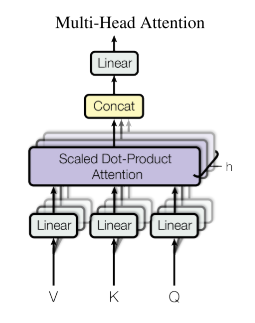

In [ ]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, n_heads, attn_pdrop):
        super(MultiHeadAttention, self).__init__()
        self.n_heads = n_heads
        self.d_k = self.d_v = d_model//n_heads

        self.WQ = nn.Linear(d_model, d_model)
        self.WK = nn.Linear(d_model, d_model)
        self.WV = nn.Linear(d_model, d_model)
        self.scaled_dot_product_attn = ScaledDotProductAttention(self.d_k, attn_pdrop)
        self.linear = nn.Linear(n_heads * self.d_v, d_model)
        #d_model=768, n_head=12, n_ctx=1024, d_head=64, bias=True, scale=False)
    def forward(self, Q, K, V, attn_mask):
        # |Q| : (batch_size, q_len(=seq_len), d_model)
        # |K| : (batch_size, k_len(=seq_len), d_model)
        # |V| : (batch_size, v_len(=seq_len), d_model)
        # |attn_mask| : (batch_size, q_len, k_len)
        batch_size = Q.size(0)

        q_heads = self.WQ(Q).view(batch_size, -1, self.n_heads, self.d_k).transpose(1, 2)
        k_heads = self.WK(K).view(batch_size, -1, self.n_heads, self.d_k).transpose(1, 2)
        v_heads = self.WV(V).view(batch_size, -1, self.n_heads, self.d_v).transpose(1, 2)
        # |q_heads| : (batch_size, n_heads, q_len, d_k),
        # |k_heads| : (batch_size, n_heads, k_len, d_k),
        # |v_heads| : (batch_size, n_heads, v_len, d_v)

        attn_mask = attn_mask.unsqueeze(1).repeat(1, self.n_heads, 1, 1)
        # |attn_mask| : (batch_size, n_heads, q_len, k_len)
        attn, attn_weights = self.scaled_dot_product_attn(q_heads, k_heads, v_heads, attn_mask)
        # |attn| : (batch_size, n_heads, q_len, d_v)
        # |attn_weights| : (batch_size, n_heads, q_len, k_len)

        attn = attn.transpose(1, 2).contiguous().view(batch_size, -1, self.n_heads * self.d_v)
        # |attn| : (batch_size, q_len, n_heads * d_v) # head는 12개, q,k,v의 각각의 hid_dim은 64
        outputs = self.linear(attn)
        # |outputs| : (batch_size, q_len, d_model)

        return outputs, attn_weights

**FFNetwork**

gelu(https://hongl.tistory.com/236)

In [ ]:
class PositionWiseFeedForwardNetwork(nn.Module):
    def __init__(self, d_model, d_ff):
        super(PositionWiseFeedForwardNetwork, self).__init__()

        self.linear1 = nn.Linear(d_model, d_ff) # d_model =768, d_ff = 768*4
        self.linear2 = nn.Linear(d_ff, d_model)
        self.gelu = nn.GELU() #relu는 부호에 따라 1이나 0을 결정적으로 곱하고, dropout은 1이나 0을 확률적으로 곱한다.
                              #이 두개념을 합친것으로 1이나 0을 부호에 따라 곱하는 것이 아니라 입력에 의존하도록함.

        nn.init.normal_(self.linear1.weight, std=0.02)
        nn.init.normal_(self.linear2.weight, std=0.02)

    def forward(self, inputs):
        # |inputs| : (batch_size, seq_len, d_model)

        outputs = self.gelu(self.linear1(inputs))
        # |outputs| : (batch_size, seq_len, d_ff)
        outputs = self.linear2(outputs)
        # |outputs| : (batch_size, seq_len, d_model)

        return outputs

**GPT2 Decoder layaer**

In [ ]:
class DecoderLayer(nn.Module):
    def __init__(self, d_model, n_heads, d_ff, attn_pdrop, resid_pdrop):
        super(DecoderLayer, self).__init__()

        self.mha = MultiHeadAttention(d_model, n_heads, attn_pdrop) # attention 거침
        self.dropout1 = nn.Dropout(resid_pdrop)
        self.layernorm1 = nn.LayerNorm(d_model, eps=1e-5)

        self.ffn = PositionWiseFeedForwardNetwork(d_model, d_ff)
        self.dropout2 = nn.Dropout(resid_pdrop)
        self.layernorm2 = nn.LayerNorm(d_model, eps=1e-5)

    def forward(self, inputs, attn_mask):
        # |inputs| : (batch_size, seq_len, d_model)
        # |attn_mask| : (batch_size, seq_len, seq_len)

        attn_outputs, attn_weights = self.mha(inputs, inputs, inputs, attn_mask)
        attn_outputs = self.dropout1(attn_outputs)
        attn_outputs = self.layernorm1(inputs + attn_outputs) #입력에도 layer norm 추가, GPT1과 다른점, RESIDUAL BLOCK을 적용.
        # |attn_outputs| : (batch_size, seq_len, d_model)
        # |attn_weights| : (batch_size, n_heads, q_len(=seq_len), k_len(=seq_len))

        ffn_outputs = self.ffn(attn_outputs)
        ffn_outputs = self.dropout2(ffn_outputs)
        ffn_outputs = self.layernorm2(attn_outputs + ffn_outputs)
        # |ffn_outputs| : (batch_size, seq_len, d_model)

        return ffn_outputs, attn_weights

**GPT Decoder**

In [ ]:
class TransformerDecoder(nn.Module):
    def __init__(self, vocab_size, seq_len, d_model, n_layers, n_heads, d_ff, embd_pdrop, attn_pdrop, resid_pdrop, pad_id):
        super(TransformerDecoder, self).__init__()
        self.pad_id = pad_id

        # layers
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.dropout = nn.Dropout(embd_pdrop)
        self.pos_embedding = nn.Embedding(seq_len+1, d_model)
        self.layers = nn.ModuleList([DecoderLayer(d_model, n_heads, d_ff, attn_pdrop, resid_pdrop) for _ in range(n_layers)])

        nn.init.normal_(self.embedding.weight, std=0.02)

    def forward(self, inputs):
        # |inputs| : (batch_size, seq_len)
        positions = torch.arange(inputs.size(1), device=inputs.device, dtype=inputs.dtype).repeat(inputs.size(0), 1) + 1
        position_pad_mask = inputs.eq(self.pad_id)
        positions.masked_fill_(position_pad_mask, 0)
        # |positions| : (batch_size, seq_len)

        outputs = self.dropout(self.embedding(inputs)) + self.pos_embedding(positions) #input 전처리 (text, position embed)
        # |outputs| : (batch_size, seq_len, d_model)

        attn_pad_mask = self.get_attention_padding_mask(inputs, inputs, self.pad_id)
        # |attn_pad_mask| : (batch_size, seq_len, seq_len)
        subsequent_mask = self.get_attention_subsequent_mask(inputs).to(device=attn_pad_mask.device)
        # |subsequent_mask| : (batch_size, seq_len, seq_len)
        attn_mask = torch.gt((attn_pad_mask.to(dtype=subsequent_mask.dtype) + subsequent_mask), 0)
        # |attn_mask| : (batch_size, seq_len, seq_len)

        attention_weights = []
        for layer in self.layers: # 12개의 LAYER 통과
            outputs, attn_weights = layer(outputs, attn_mask)
            # |outputs| : (batch_size, seq_len, d_model)
            # |attn_weights| : (batch_size, n_heads, seq_len, seq_len)
            attention_weights.append(attn_weights)

        return outputs, attention_weights

    def get_attention_padding_mask(self, q, k, pad_id):
        attn_pad_mask = k.eq(pad_id).unsqueeze(1).repeat(1, q.size(1), 1)
        # |attn_pad_mask| : (batch_size, q_len, k_len)

        return attn_pad_mask

    def get_attention_subsequent_mask(self, q):
        bs, q_len = q.size()
        subsequent_mask = torch.ones(bs, q_len, q_len).triu(diagonal=1)
        # |subsequent_mask| : (batch_size, q_len, q_len)

        return subsequent_mask

In [ ]:
class GPT(nn.Module):
    def __init__(self,
                 vocab_size,
                 seq_len=512,
                 d_model=768,
                 n_layers=12,
                 n_heads=12,
                 d_ff=3072,
                 embd_pdrop=0.1,
                 attn_pdrop=0.1,
                 resid_pdrop=0.1,
                 pad_id=0):
        super(GPT, self).__init__()

        self.decoder = TransformerDecoder(vocab_size, seq_len, d_model, n_layers, n_heads, d_ff,
                                          embd_pdrop, attn_pdrop, resid_pdrop, pad_id)

    def forward(self, inputs):
        # |inputs| : (batch_size, seq_len)

        outputs, attention_weights = self.decoder(inputs)
        # |outputs| : (batch_size, seq_len, d_model)
        # |attention_weights| : [(batch_size, n_heads, seq_len, seq_len)] * n_layers

        return outputs, attention_weights

GPT Training

In [ ]:
import time
import json
from pathlib import Path

import torch
import torch.nn as nn
from torch.nn.parallel import DistributedDataParallel
from torch.utils.tensorboard import SummaryWriter
from radam import RAdam

from model import GPT, GPTLMHead, GPTClsHead

In [ ]:
def timeit(method):
    def timed(*args, **kw):
        _args = args[0].args

        ts = time.time()
        result = method(*args, **kw)
        te = time.time()

        if _args.distributed:
            if _args.local_rank == 0:
                print('Function Time: {}\t>\t{:.0f} min {:.0f} sec'.format(method.__name__, (te-ts)//60, (te-ts)%60))
        else:
            print('Function Time: {}\t>\t{:.0f} min {:.0f} sec'.format(method.__name__, (te-ts)//60, (te-ts)%60))

        return result
    return timed

class Trainer:
    def __init__(self, args, train_loader, test_loader, tokenizer):
        self.args = args
        self.train_loader = train_loader
        self.test_loader = test_loader
        self.tokenizer = tokenizer
        self.vocab_size = tokenizer.vocab_size
        self.pad_id = tokenizer.pad_token_id
        self.eos_id = tokenizer.eos_token_id
        self.device = torch.device('cuda' if torch.cuda.is_available() and not args.no_cuda else 'cpu', args.local_rank)
        self.writer = SummaryWriter() if args.local_rank in [-1, 0] else None
        self.n_gpus = torch.distributed.get_world_size() if args.distributed else torch.cuda.device_count()
        assert args.pretrain != args.finetune # Do not set both finetune and pretrain arguments to the same (True, False)

        if args.pretrained_model:
            self.gpt = torch.load(args.pretrained_model)
        else:
            self.gpt = GPT(vocab_size=self.vocab_size,
                           seq_len=args.max_seq_len,
                           d_model=args.hidden,
                           n_layers=args.n_layers,
                           n_heads=args.n_attn_heads,
                           d_ff=args.ffn_hidden,
                           embd_pdrop=args.embd_dropout,
                           attn_pdrop=args.attn_dropout,
                           resid_pdrop=args.resid_dropout,
                           pad_id=self.pad_id)

        if args.pretrain:
            self.model = GPTLMHead(self.gpt)
            self.model.to(self.device)
        if args.finetune:
            with open(args.cached_label_dict, 'r') as file:
                label_dict = json.load(file)
            self.model = GPTClsHead(self.gpt, n_class=len(label_dict), cls_token_id=self.eos_id)
            self.model.to(self.device)

        if args.distributed:
            self.model = DistributedDataParallel(self.model, device_ids=[args.local_rank], output_device=args.local_rank)

        self.optimizer = RAdam(self.model.parameters(), args.lr)
        self.criterion = nn.CrossEntropyLoss(ignore_index = self.pad_id).to(self.device)
        self.cls_criterion = nn.CrossEntropyLoss().to(self.device)

    @timeit
    def train(self, epoch):
        if self.args.pretrain:
            self.pretrain(epoch)
        if self.args.finetune:
            self.finetune(epoch)

    def pretrain(self, epoch):
        losses = 0
        n_batches, n_samples = len(self.train_loader), len(self.train_loader.dataset)

        self.model.train()
        for i, batch in enumerate(self.train_loader):
            inputs = batch[0].to(self.device)
            targets = inputs[:, 1:].contiguous()
            # |inputs| : (batch_size, seq_len), |targets| : (batch_size, seq_len-1)

            lm_logits = self.model(inputs)
            lm_logits = lm_logits[:, :-1].contiguous()
            # |lm_logits| : (batch_size, seq_len-1, vocab_size)

            loss = self.criterion(lm_logits.view(-1, self.vocab_size), targets.view(-1))
            losses += loss.item()

            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

            if self.args.local_rank in [-1, 0]:
                self.writer.add_scalar('Loss/pre-train', loss.item(), ((epoch-1)*n_batches)+i)
                if i % (n_batches//5) == 0 and i != 0:
                    print('Iteration {} ({}/{})\tLoss: {:.4f}'.format(i, i, n_batches, losses/i))

        print('Train Epoch {} [rank: {}]\t>\tLoss: {:.4f}'.format(epoch, self.args.local_rank, losses/n_batches))

    def finetune(self, epoch):
        losses, accs = 0, 0
        n_batches, n_samples = len(self.train_loader), len(self.train_loader.dataset) # n_batches = batch size per GPU

        self.model.train()
        for i, batch in enumerate(self.train_loader):
            inputs, labels = map(lambda x: x.to(self.device), batch)
            # |inputs| : (batch_size, seq_len), |labels| : (batch_size)

            lm_logits, cls_logits = self.model(inputs)
            lm_logits = lm_logits[:, :-1].contiguous()
            # |lm_logits| : (batch_size, seq_len-1, vocab_size), |cls_logits| : (batch_size, n_class)

            lm_loss = self.criterion(lm_logits.view(-1, self.vocab_size), inputs[:, 1:].contiguous().view(-1))
            cls_loss = self.cls_criterion(cls_logits, labels)
            loss = cls_loss + (self.args.auxiliary_ratio * lm_loss)

            losses += loss.item()
            acc = (cls_logits.argmax(dim=-1) == labels).to(dtype=cls_logits.dtype).mean()
            accs += acc

            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

            if self.args.local_rank in [-1, 0]:
                self.writer.add_scalar('Loss/fine-tune', loss.item(), ((epoch-1)*n_batches)+i)
                self.writer.add_scalar('Accuracy/fine-tune', acc, ((epoch-1)*n_batches)+i)
                if i % (n_batches//5) == 0 and i != 0:
                    print('Iteration {} ({}/{})\tLoss: {:.4f} Acc: {:.1f}%'.format(i, i, n_batches, losses/i, accs/i*100.))

        print('Train Epoch {} [rank: {}]\t>\tLoss: {:.4f} / Acc: {:.1f}%'.format(epoch, self.args.local_rank, losses/n_batches, accs/n_batches*100.))

    def evaluate(self, epoch):
        losses, accs = 0, 0
        n_batches, n_samples = len(self.test_loader), len(self.test_loader.dataset)

        self.model.eval()
        with torch.no_grad():
            for i, batch in enumerate(self.test_loader):
                if self.args.pretrain:
                    inputs = batch.to(self.device)
                    targets = inputs[:, 1:].contiguous()

                    lm_logits = self.model(inputs)
                    lm_logits = lm_logits[:, :-1].contiguous()

                    loss = self.criterion(lm_logits.view(-1, self.vocab_size), targets.view(-1))
                    losses += loss.item()

                    if self.args.local_rank in [-1, 0]:
                        self.writer.add_scalar('Loss/pre-train(eval)', loss.item(), ((epoch-1)*n_batches)+i)

                elif self.args.finetune:
                    inputs, labels = map(lambda x: x.to(self.device), batch)

                    lm_logits, cls_logits = self.model(inputs)
                    lm_logits = lm_logits[:, :-1].contiguous()

                    lm_loss = self.criterion(lm_logits.view(-1, self.vocab_size), inputs[:, 1:].contiguous().view(-1))
                    cls_loss = self.cls_criterion(cls_logits, labels)
                    loss = cls_loss + (self.args.auxiliary_ratio * lm_loss)

                    losses += loss.item()
                    acc = (cls_logits.argmax(dim=-1) == labels).to(dtype=cls_logits.dtype).mean()
                    accs += acc

                    if self.args.local_rank in [-1, 0]:
                        self.writer.add_scalar('Loss/fine-tune(eval)', loss.item(), ((epoch-1)*n_batches)+i)
                        self.writer.add_scalar('Accuracy/fine-tune(eval)', acc, ((epoch-1)*n_batches)+i)

        print('Eval Epoch {} [rank: {}]\t>\tLoss: {:.4f} / Acc: {:.1f}%'.format(epoch, self.args.local_rank, losses/n_batches, accs/n_batches*100.))

    def save(self, epoch, model_prefix='model', root='.model'):
        path = Path(root) / (model_prefix + '.ep%d' % epoch)
        if not path.parent.exists():
            path.parent.mkdir()

        if self.args.distributed:
            if self.args.local_rank == 0:
                torch.save(self.gpt, path)
        else:
            torch.save(self.gpt, path)